### Импорты:

In [2]:
# !pip3 install lime
# !pip3 install shap
# !pip3 install category_encoders
# !pip install xgboost

In [3]:
import pandas as pd
import numpy as np
import statistics

import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from imblearn.under_sampling import RandomUnderSampler

# Models
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import plot_tree 
from sklearn.linear_model import RidgeClassifier
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from keras.regularizers import l2

# Pipline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, 
                                   LabelEncoder, MinMaxScaler)
from sklearn.impute import SimpleImputer
from category_encoders import HelmertEncoder
from category_encoders import CountEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Metrix
from sklearn.metrics import mean_absolute_error, f1_score, accuracy_score
from sklearn.metrics import (roc_curve, auc, roc_auc_score,
                             confusion_matrix, mean_squared_error)
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# pd.set_option('display.max_columns', None)
# pd.set_option("display.max_rows", None, "display.max_columns", None)
# pd.reset_option('all')
from tabulate import tabulate

#Interpretation
import shap
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer

from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

### Вспомогательные функции:

Функция **fix_data** устраняет дисбаланс в данных с помощью RandomUnderSampler:

In [4]:
def fix_data(X, y):
  undersample = RandomUnderSampler(sampling_strategy=0.4) # majority
  X_under, y_under = undersample.fit_resample(X, y)

  return X_under, y_under

Функция **plot_feature** для построения наглядного распределения каждого признака: 

In [5]:
# https://towardsdatascience.com/financial-data-analysis-bf4b5e78c45c
# Эта функция строит графики с учетом того, категориальный ли признак

def plot_feature(col_name, isContinuous, df):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), dpi=90)

    # Plot without loan status
    if isContinuous:
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
        plt.xticks(rotation = 90)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name)
    plt.xticks(rotation = 90)

    # Plot with loan status
    if isContinuous:
        sns.boxplot(x=col_name, y='TARGET', data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by Loan Status')
        plt.xticks(rotation = 90)
    else:
        dt = df.groupby(col_name)['TARGET'].value_counts(normalize=True).to_frame('proportion').reset_index()
        sns.barplot(x = col_name, y = 'proportion', hue= "TARGET", data = dt)

        # dt = application_data.groupby('NAME_CONTRACT_TYPE')['TARGET'].value_counts(normalize=True).to_frame('proportion').reset_index()
        # sns.barplot(x = 'NAME_CONTRACT_TYPE', y = 'proportion', hue= "TARGET", data = dt)

        ax2.set_ylabel('Loan fraction')
        ax2.set_title('Loan status')
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)

    plt.tight_layout()
    plt.savefig('graph_{}.png'.format(col_name))
    # plt.show()

Функция **gisto** для построения гистограммы распределения для численных признаков:

In [6]:
def gisto(col_name, x_size, y_size, data):
  plt.ticklabel_format(style='plain')
  data[col_name].hist(bins=50, color='purple', figsize=(x_size, y_size))

  plt.title('Гистограмма {}'.format(col_name), size = 8)
  plt.xlabel('{}'.format(col_name), size = 8)
  plt.ylabel('Количество кредитов', size = 8)
  plt.show()
  plt.savefig('гистограмма_{}.png'.format(col_name))

Функция **colunmValues** для подсчета пропусков, уникальных значений и пр у определенного признака:

In [7]:
def columnValues(df):
    row = [df.nunique(), (df == 0).sum(axis=0), df.isna().sum(), round(df.isna().sum() / len(df) * 100, 1), df.dtypes]
    return row

Функция **showcase** для наглядного описания витрины данных:

In [8]:
def showcase(df_get):
  data_stat = []
  for column in df_get:
      data_stat.append([column] + columnValues(df_get[column]))

  col_align = ["left", "right", "right", "right", "right", "left"]
  print(tabulate(data_stat, headers=['Column', 'Count Unique', 'Count Zeros', 'Count NaNs','% of NaNs', 'data type'], tablefmt='orgtbl', colalign=col_align))

Функция **colunmTypes** для вывода всех типов данных для всех признаков:

In [9]:
def columnTypes(df):
  for column in df:
    print(df[column].apply(type).value_counts().to_dict(), column)

Метрика **Gini** в виде функции просто для удобства использования:

In [10]:
def Gini(y_true, y_pred):
  return (2*roc_auc_score(y_true.values, y_pred) - 1)

# 📌 Функции с предобработкой данных

## «Ручная» предобработка

In [11]:
def base_pre_processing(data_before):

  data = data_before.copy()

  # Удалим данные с процентом пропуска больше 40%: 
  for colunm in data.columns.tolist():
    if round(data[colunm].isna().sum() / len(data[colunm]) * 100, 1) > 60:
      data = data.drop(colunm, axis='columns')

  # Удаляем категориальные признаки, где количество уникальных значений больше 40:
  # for column in data.columns.tolist():
  #   if data[column].nunique() > 40 and data.dtypes[column] == object:
  #     data = data.drop(column, axis='columns')

  # Удаляем колонку индексов:
  data = data.drop('SK_ID_CURR', axis='columns')

  # Удаляем повторы:
  data.drop_duplicates(inplace=True)

  # Заполняем частично NaN значения
  # (в этих колонках со смешанным типом данных просто присутствует np.nan, который заменим строковыми данными)
  data['NAME_TYPE_SUITE'] = data['NAME_TYPE_SUITE'].replace([np.nan], ['UNK'], inplace=True)
  data['NAME_TYPE_SUITE'] = data['NAME_TYPE_SUITE'].astype(str)

  data['OCCUPATION_TYPE'] = data['OCCUPATION_TYPE'].replace([np.nan], ['UNK'], inplace=True)
  data['OCCUPATION_TYPE'] = data['OCCUPATION_TYPE'].astype(str)

  # Тут были выбросы, сильно влияющие на интерпретацию:
  data = data.loc[data['AMT_INCOME_TOTAL'] < 1500000]

  # При наличии заполняем оставиеся пропуски:
  data.fillna(method='ffill', inplace=True) # старая версия заполнения пропусков
  data.fillna(method='bfill', inplace=True)

  # numeric_features_data = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
  # cat_features = data.select_dtypes(include=['object']).columns.tolist()

  # imputer = KNNImputer(n_neighbors=3)
  # imputer.fit(data[numeric_features_data])
  # data_num = imputer.transform(data[numeric_features_data])

  # data = pd.concat([data_num, data[cat_features]], axis=0)

  return data

## WoE обработка 

In [12]:
# Преобразование WOE

def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
      
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()

    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

Функция **woe_for_all** делает преобразование WoE для всего набора данных, отбирает признаки по заданному значению Information Value, и возвращает 4 готовых разбитых выборки для обучения:

In [13]:
def woe_for_all(df_woe, iv_threshold):

  numeric_features = df_woe.select_dtypes(include=['float64', 'int64']).columns.tolist()
  categorical = df_woe.select_dtypes(include=['object']).columns.tolist()

  # Делим интервальные переменные на бины 
  for feature in numeric_features:
      df_woe[feature + '_bin'] = pd.qcut(df_woe[feature], 10, duplicates='drop')
      df_woe[feature + '_bin'] = df_woe[feature + '_bin'].cat.add_categories("0-0").fillna("0-0")

  for feature in categorical:
      df_woe[feature] = df_woe[feature].fillna("0-0") 

  numeric_features.remove('TARGET')

  train, test = train_test_split(df_woe, test_size=0.3, random_state=40, stratify=df_woe['TARGET'])

  # Сохраняем все Information Values значения для последующего отбора
  scorecard = pd.DataFrame()
  save_iv_num = pd.DataFrame(columns=['num_feature', 'IV'])
  save_iv_categ = pd.DataFrame(columns=['categ_feature', 'IV'])

  # print('Значения Information value для численных признаков:')
  for feature in numeric_features:
      
      data, iv = calculate_woe_iv(train, feature + '_bin', 'TARGET')
      save_iv_num.loc[len(save_iv_num)] = [feature, iv]
      data['feature'] = feature

      train = train.merge(data[['Value', 'WoE']], how='inner', left_on=feature + '_bin', right_on='Value' )
      train = train.rename(columns={'WoE':'WoE'+ '_' + feature})
      
      train = train.drop(columns = [feature, feature + '_bin', 'Value'])
      
      test = test.merge(data[['Value', 'WoE']], how='inner', left_on=feature + '_bin', right_on='Value' )
      test = test.rename(columns={'WoE':'WoE' + '_' + feature})

      test = test.drop(columns = [feature, feature + '_bin', 'Value'])
      scorecard = pd.concat([scorecard, data[['feature', 'Value', 'WoE']]])
      # scorecard = scorecard.append(df[['feature', 'Value', 'WoE']])
      #print(feature, ':', iv)

  # print('Значения Information value для категориальных признаков:')
  for feature in categorical:
      data, iv = calculate_woe_iv(train, feature , 'TARGET')
      data['feature'] = feature
      train = train.merge(data[['Value', 'WoE']], how='inner', left_on=feature, right_on='Value' )
      train = train.rename(columns={'WoE':'WoE'+'_'+feature})
      train = train.drop(columns = [feature, 'Value'])
      
      test = test.merge(data[['Value', 'WoE']], how='inner', left_on=feature, right_on='Value' )
      test = test.rename(columns={'WoE':'WoE'+'_'+feature})
      test = test.drop(columns = [feature, 'Value'])
      scorecard = pd.concat([scorecard, data[['feature', 'Value', 'WoE']]])
      save_iv_categ.loc[len(save_iv_categ)] = [feature, iv]
      # print(feature, ':', iv)

  # Оставляем только значимые признаки с выбранным порогом
  good_categ = save_iv_categ.loc[save_iv_categ['IV'] > iv_threshold]
  good_num = save_iv_num.loc[save_iv_num['IV'] > iv_threshold]

  # Формируем итоговый набор признаков для обучения
  features = test.columns.tolist()
  features.remove('TARGET')
  features.remove('TARGET_bin')

  for _ in features:
    if _[4:] in good_num['num_feature'] or _[4:] in good_categ['categ_feature']:
      continue
    else: features.remove(_)

  X_train = train[features]
  X_test = test[features]
  y_train = train['TARGET']
  y_test = test['TARGET']

  return X_train, y_train, X_test, y_test 

Функция **woe_for_cat** делает преобразование WoE для всего набора данных, отбирает признаки по заданному значению Information Value, и возвращает 4 готовых разбитых выборки для обучения:

In [14]:
def woe_for_cat(df_woe, iv_threshold):

  numeric_features = df_woe.select_dtypes(include=['float64', 'int64']).columns.tolist()
  categorical = df_woe.select_dtypes(include=['object']).columns.tolist()

  for feature in categorical:
      df_woe[feature] = df_woe[feature].fillna("0-0") 

  numeric_features.remove('TARGET')

  train, test = train_test_split(df_woe, test_size=0.3, random_state=40, stratify=df_woe['TARGET'])

  # Сохраняем все Information Values значения для последующего отбора
  scorecard = pd.DataFrame()
  save_iv_categ = pd.DataFrame(columns=['categ_feature', 'IV'])

  # print('Значения Information value для категориальных признаков:')
  for feature in categorical:
      data, iv = calculate_woe_iv(train, feature , 'TARGET')
      data['feature'] = feature

      train = train.merge(data[['Value', 'WoE']], how='inner', left_on=feature, right_on='Value' )
      train = train.rename(columns={'WoE':'WoE'+'_'+feature})
      train = train.drop(columns = [feature, 'Value'])
      
      test = test.merge(data[['Value', 'WoE']], how='inner', left_on=feature, right_on='Value' )
      test = test.rename(columns={'WoE':'WoE'+'_'+feature})
      test = test.drop(columns = [feature, 'Value'])
      
      scorecard = pd.concat([scorecard, data[['feature', 'Value', 'WoE']]])
      save_iv_categ.loc[len(save_iv_categ)] = [feature, iv]

  # Оставляем только значимые признаки с выбранным порогом
  good_categ = save_iv_categ.loc[save_iv_categ['IV'] > iv_threshold]

  # Формируем итоговый набор признаков для обучения
  cat_features = test.columns.tolist()
  cat_features.remove('TARGET')

  for _ in cat_features:
    if _[4:] in categorical:
      if _[4:] in good_categ['categ_feature']:
        continue
      else: 
        cat_features.remove(_)

  # Проблема в том, что на этапе конкатенации дублируются колонки с признаками, axis{0/’index’, 1/’columns’}
  X_train = train[cat_features]
  y_train = train['TARGET']
  X_test = test[cat_features]
  y_test = test['TARGET']

  # print('cat_features: \n:' , cat_features)

  return X_train, y_train, X_test, y_test

# 📌 Функции для интерпретации моделей

## SHAP 

In [106]:
def shap_mean(model, X, model_name, preproc_name, encode):
  explainer = shap.Explainer(model, X)

  shap_values = explainer(X)
  plt.title('Mean SHAP values')
  shap.plots.bar(shap_values)

  print("Model: ", model_name)
  print("Pre-processing type: ", preproc_name)
  print("Encoding type: ", encode)

In [16]:
def shap_base(model, X, X_test, model_name, preproc_name, encode):

  explainer = shap.Explainer(model, X)
  shap_values = explainer.shap_values(X_test)

  shap.initjs()
  plt.title('Summary SHAP values')
  shap.summary_plot(shap_values, X_test)

  print("Model: ", model_name)
  print("Pre-processing type: ", preproc_name)
  print("Encoding type: ", encode)

## Feature_importances_

In [17]:
def feature_imp(model, X):
  plt.figure(figsize=(12, 25))
  plt.barh(X.columns, model.feature_importances_)

  plt.show()

## LIME

In [18]:
def lime_interp(model, X_train, X_test):
    explainer = LimeTabularExplainer(
        X_train.values, feature_names=X_train.columns, class_names=["0", "1"], discretize_continuous=False)

    exp = explainer.explain_instance(X_test.iloc[0], model.predict_proba)
    exp.show_in_notebook()

# Обзор данных

In [197]:
df = pd.read_csv("application_train.csv", encoding='latin1')

In [198]:
df['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Нормализуем соотношение дефолтов и погашений к 30/70:

In [91]:
df_fix = df.copy()

In [92]:
X = df_fix.drop(['TARGET'], axis=1)
y = df_fix['TARGET']

In [93]:
X_new, y_new = fix_data(X, y)

In [94]:
y_new.value_counts()

0    62062
1    24825
Name: TARGET, dtype: int64

In [95]:
df = pd.concat([X_new, y_new], axis=1)

In [96]:
df

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0          182044         Cash loans           F            N               Y   
1          256240         Cash loans           F            N               N   
2          253795         Cash loans           F            N               N   
3          367274         Cash loans           M            Y               Y   
4          414645         Cash loans           M            N               Y   
...           ...                ...         ...          ...             ...   
86882      456186         Cash loans           M            N               N   
86883      456215         Cash loans           F            N               N   
86884      456225         Cash loans           M            N               Y   
86885      456233         Cash loans           F            N               Y   
86886      456254         Cash loans           F            N               Y   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                 1           99000.0     76500.0       8365.5   
1                 0           90000.0    148140.0      10908.0   
2                 1          135000.0    263686.5      25816.5   
3                 0          157500.0    450000.0      21109.5   
4                 0           90900.0    272520.0      21658.5   
...             ...               ...         ...          ...   
86882             1          207000.0    450000.0      32746.5   
86883             1          144000.0   1303200.0      46809.0   
86884             0          225000.0    297000.0      19975.5   
86885             0          225000.0    521280.0      23089.5   
86886             0          171000.0    370107.0      20205.0   

       AMT_GOODS_PRICE  ... FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
0              76500.0  ...                0                0   
1             112500.0  ...                0                0   
2             238500.0  ...                0                0   
3             450000.0  ...                0                0   
4             225000.0  ...                0                0   
...                ...  ...              ...              ...   
86882         450000.0  ...                0                0   
86883        1125000.0  ...                0                0   
86884         297000.0  ...                0                0   
86885         450000.0  ...                0                0   
86886         319500.0  ...                0                0   

      FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                    0                        0.0                       0.0   
1                    0                        0.0                       0.0   
2                    0                        0.0                       0.0   
3                    0                        0.0                       0.0   
4                    0                        0.0                       0.0   
...                ...                        ...                       ...   
86882                0                        0.0                       0.0   
86883                0                        0.0                       0.0   
86884                0                        0.0                       0.0   
86885                0                        0.0                       0.0   
86886                0                        0.0                       0.0   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                             0.0                        0.0   
1                             0.0                        0.0   
2                             0.0                        0.0   
3                             0.0                        0.0   
4                             0.0                        1.0   
...                           ...                        ...   
86882                         0.0                        0.0   

Здесь мы можем отследить, в каких признаках слишком большой процент пропущенных значений. Мы можем в дальнейшем попробовать использовать их в комбинации, или заполнить пропуски, или удалить, если они будут сильно зашумлять данные.

In [ ]:
# showcase(df)

Далее посмотрим на признаки, где смешанный тип данных:

In [ ]:
columnTypes(df)

Данные после базовой предобработки:

In [ ]:
df_base = df.copy()

In [ ]:
df_base = base_pre_processing(df_base)

In [ ]:
showcase(df_base)

Данные на WoE на всех данных:

In [ ]:
df_woe_all = df.copy()

In [ ]:
X_train, y_train, X_test, y_test = woe_for_all(df_woe_all, 0.02)

In [ ]:
X = pd.concat([X_train, X_test], axis=0)

In [ ]:
y = pd.concat([y_train, y_test], axis=0)

In [ ]:
df_woe_all = pd.concat([X, y], axis=1)

In [ ]:
showcase(df_woe_all)

In [ ]:
df_woe_all

Данные на WoE для категориальных и базовой предобработке: 

In [ ]:
df_woe_cat = df.copy()

In [ ]:
df_woe_cat = base_pre_processing(df_woe_cat)

In [ ]:
X_train, y_train, X_test, y_test = woe_for_cat(df_woe_cat, 0.02)

In [ ]:
X = pd.concat([X_train, X_test], axis=0)

In [ ]:
y = pd.concat([y_train, y_test], axis=0)

In [ ]:
df_woe_cat = pd.concat([X, y], axis=1)

In [ ]:
df_woe_cat

In [ ]:
showcase(df_woe_cat)

# 🔹 Логистическая регрессия | все модели 

## 🌸 Универсальная функция для обучения 

In [28]:
def logregression(data_log):

  X = data_log.drop(['TARGET'], axis=1)
  y = data_log['TARGET']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=40, stratify=y_train)


  t = train_c(X_train, y_train, X_val, y_val)
  # solv = train_solver(X_train, y_train, X_val, y_val)
  # penal = train_penalty(X_train, y_train, X_val, y_val)

  print("C =", t)
  # print("Solver = ", solv)
  # print("Penalty = ", penal, '\n')

  model = LogisticRegression(C=t, solver='liblinear', penalty='l2', max_iter = 1000)
  model.fit(X_train, y_train)

  y_pred_train = model.predict_proba(X_train)
  y_pred_val = model.predict_proba(X_val)

  y_pred_test = model.predict(X_test)
  mat = confusion_matrix(y_test, y_pred_test)
  labels = ['0', '1']
  
  sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='crest',
              xticklabels=labels, yticklabels=labels)
  
  plt.xlabel('Predicted label')
  plt.ylabel('Actual label')

  precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred_test, average='binary')

  print("Precision: ", precision)
  print("Recall: ", recall)
  print("F1-score: ", f1_score)

  ras = roc_auc_score(y_val.values, y_pred_val[:, 1])
  print("ROC_AUC: ", ras)

  return model, X, X_test, X_train

In [29]:
def train_c(X_train, y_train, X_test, y_test):
  best_g = 0
  best_c = 0

  for t in [0.1, 0.3, 0.5, 0.7, 1]:
    clf = LogisticRegression(random_state=42, C=t, max_iter = 1000).fit(X_train, y_train)

    pred = clf.predict_proba(X_test)
    er = Gini(y_test, pred[:, 1])

    if best_g == 0 or er > best_g:
      best_g = er
      best_c = t

  return best_c

In [30]:
def train_solver(X_train, y_train, X_test, y_test):
  best_g = 0
  best_solver = 0

  for s in ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']:
    clf = LogisticRegression(random_state=42, solver=s, max_iter = 1000).fit(X_train, y_train)

    pred = clf.predict_proba(X_test)
    er = Gini(y_test, pred[:, 1])

    if best_g == 0 or er > best_g:
      best_g = er
      best_solver = s

  return best_solver

In [31]:
def train_penalty(X_train, y_train, X_test, y_test):
  best_g = 0
  best_penalty = 0

  for p in ['l1', 'l2', 'elasticne']:
    clf = LogisticRegression(random_state=42, penalty=p, max_iter = 1000).fit(X_train, y_train)

    pred = clf.predict_proba(X_test)
    er = Gini(y_test, pred[:, 1])

    if best_g == 0 or er > best_g:
      best_g = er
      best_penalty = p

  return best_penalty

## 🌸 Логистическая регрессия на OneHot  (DONE)

In [32]:
df_log = df.copy()

Ручная предобработка:

In [33]:
df_log = base_pre_processing(df_log)

In [ ]:
# df_log = df_log.drop(['AMT_GOODS_PRICE', 'AMT_CREDIT'], axis=1)

Кодируем OheHot:

In [34]:
df_log = pd.get_dummies(df_log)

Обучаем лог регрессию:

In [263]:
model, X, X_test, X_train = logregression(df_log)

Интерпретируем:

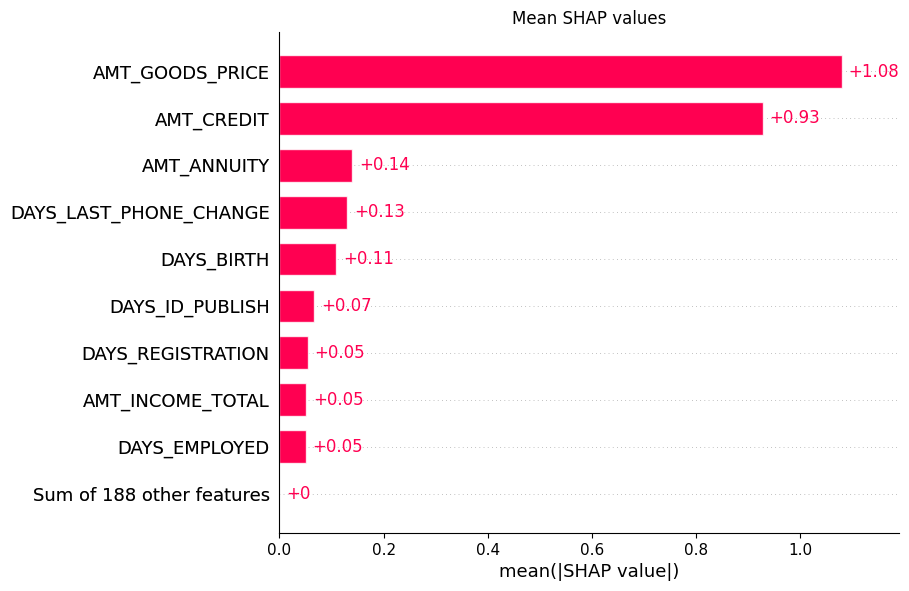

Model:  Logistic Regression
Pre-processing type:  Basic
Encoding type:  OneHot Encoding


In [37]:
shap_mean(model, X_test, "Logistic Regression", "Basic", "OneHot Encoding")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


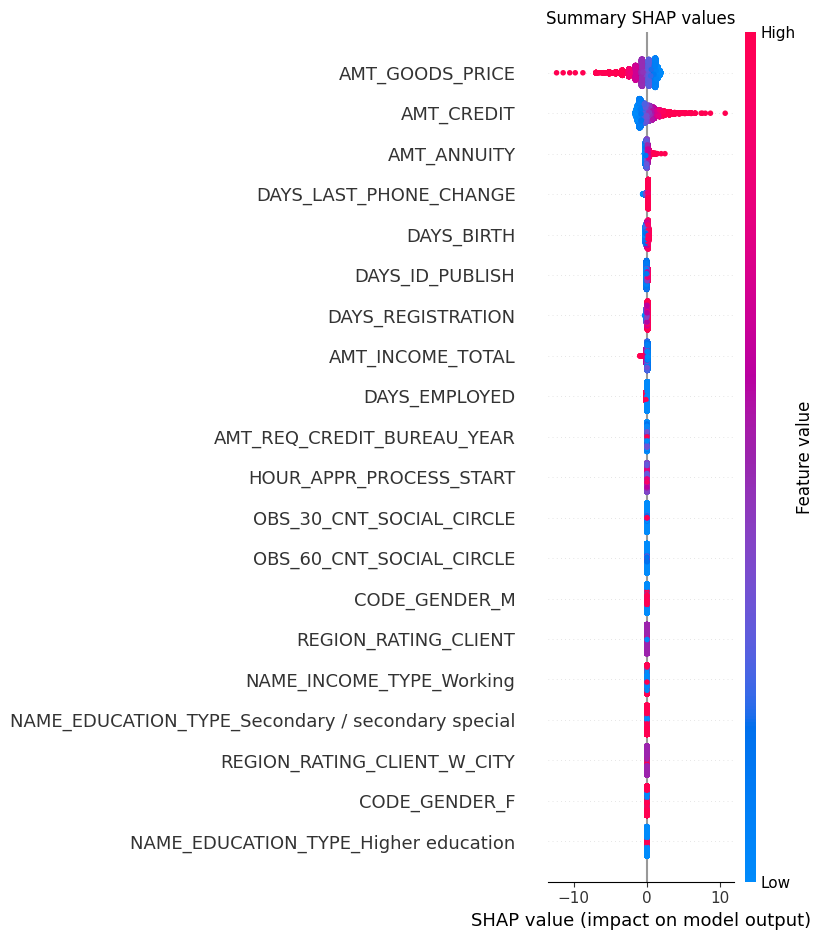

Model:  Logistic Regression
Pre-processing type:  Basic
Encoding type:  OneHot Encoding


In [38]:
shap_base(model, X, X_test, "Logistic Regression", "Basic", "OneHot Encoding")

In [39]:
lime_interp(model, X_train, X_test)

X does not have valid feature names, but LogisticRegression was fitted with feature names


## 🌸 Логистическая регрессия на HelmertEncoder (DONE)

In [40]:
df_helmet = df.copy()

Ручная предобработка:

In [41]:
df_helmet = base_pre_processing(df_helmet)

Кодируем Helmert:

In [42]:
df_helmet = pd.get_dummies(df_log)

In [43]:
numeric_features_helmet = df_helmet.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_helmet = df_helmet.select_dtypes(include=['object']).columns.tolist()

In [44]:
helmert_enc = HelmertEncoder(cols=categorical_helmet, drop_invariant=True)
X_categ = helmert_enc.fit_transform(df_helmet[categorical_helmet])

In [45]:
df_helmet_done = pd.concat([X_categ, df_helmet[numeric_features_helmet]], axis=1)

Обучаем лог регрессию:

In [264]:
model, X, X_test, X_train = logregression(df_helmet_done)

Интерпретируем:

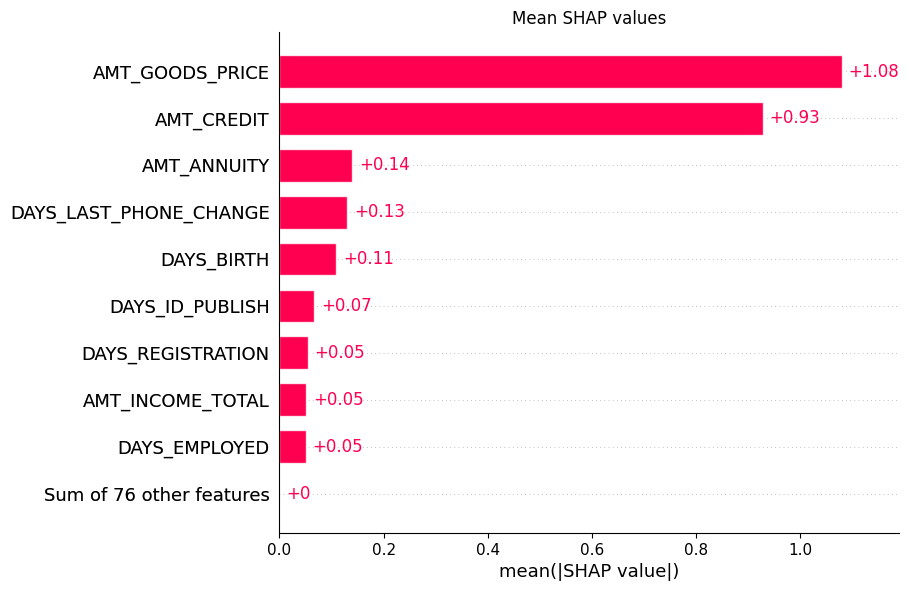

Model:  Logistic Regression
Pre-processing type:  Basic
Encoding type:  Helmert Encoding


In [47]:
shap_mean(model, X_test, "Logistic Regression", "Basic", "Helmert Encoding")

In [ ]:
shap_base(model, X, X_test, "Logistic Regression", "Basic", "Helmert Encoding")

In [ ]:
lime_interp(model, X_train, X_test)

## 🌸 Логистическая регрессия на Frequency Encoding (DONE)

In [48]:
df_freq = df.copy()

Ручная предобработка:

In [49]:
df_freq = base_pre_processing(df_freq)

Кодируем Frequency:

In [50]:
categorical_freq = df_freq.select_dtypes(include=['object']).columns.tolist()
numeric_features_freq = df_freq.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [51]:
encoder = CountEncoder(cols=categorical_freq, normalize=True)
df_freq_cat = encoder.fit_transform(df_freq[categorical_freq])

In [52]:
df_freq_done = pd.concat([df_freq_cat, df_freq[numeric_features_freq]], axis=1)

Обучаем лог регрессию:

In [265]:
model, X, X_test, X_train = logregression(df_freq_done)

Интерпретируем:

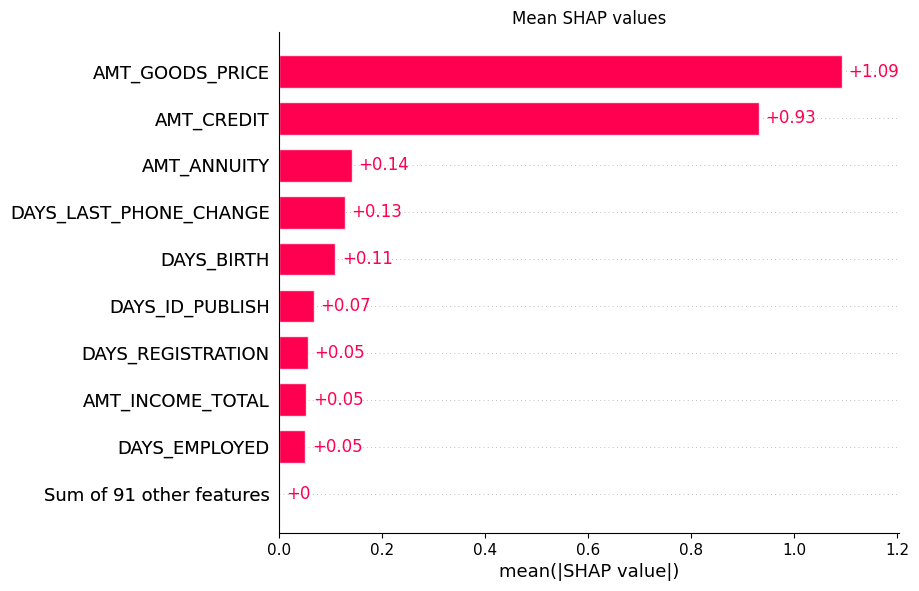

Model:  Logistic Regression
Pre-processing type:  Basic
Encoding type:  Frequency Encoding


In [54]:
shap_mean(model, X, "Logistic Regression", "Basic", "Frequency Encoding")

In [ ]:
shap_base(model, X, X_test, "Logistic Regression", "Basic", "Frequency Encoding")

In [ ]:
lime_interp(model, X_train, X_test)

## 🌸 Логистическая регрессия на WoE для всех признаков (DONE)

In [55]:
df_woe_all = df.copy()

Все признаки кодируем через WoE и отбираем по Information Value с порогом 0.02:

In [56]:
X_train, y_train, X_test, y_test = woe_for_all(df_woe_all, 0.02)

divide by zero encountered in log


Обучаем логистическую регрессию (не через функцию тк у нас уже разделен датасет и так просто удобнее):

In [57]:
model = LogisticRegression(max_iter = 1000, C=0.01)
model.fit(X_train, y_train)

y_pred_train = model.predict_proba(X_train)
y_pred_test = model.predict_proba(X_test)

ras = roc_auc_score(y_test.values, y_pred_test[:, 1])
print("RAS: ", ras)

RAS:  0.6879821519580913


Precision:  0.5919047619047619
Recall:  0.166890440386681
F1-score:  0.2603686635944701


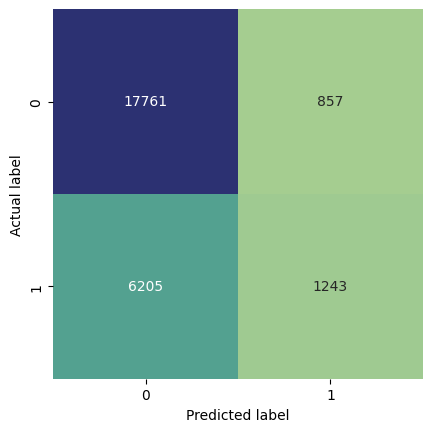

In [58]:
y_pred_test = model.predict(X_test)
mat = confusion_matrix(y_test, y_pred_test)
labels = ['0', '1']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='crest',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred_test, average='binary')

print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1_score)

Интерпретируем:

In [59]:
X = pd.concat([X_train, X_test], axis=0)

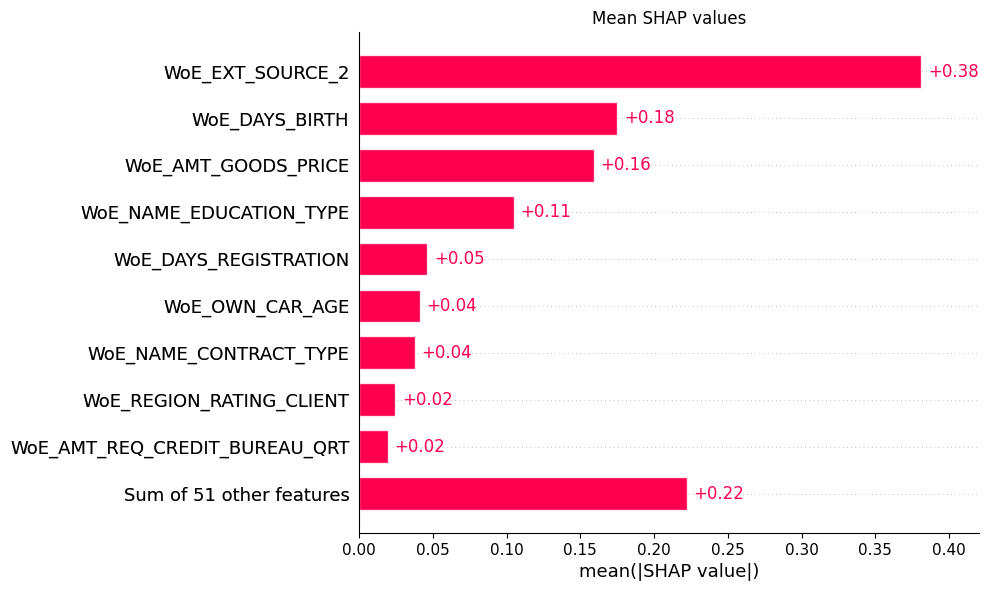

Model:  Logistic Regression
Pre-processing type:  WoE for all
Encoding type:  WoE and IV


In [60]:
shap_mean(model, X_train, "Logistic Regression", "WoE for all", "WoE and IV")

In [ ]:
shap_base(model, X_train, X_test, "Logistic Regression", "WoE for all", "WoE and IV")

In [ ]:
lime_interp(model, X_train, X_test)

Высчитываем средние потери при использовании этой модели от одного ложновыданного кредита:

In [ ]:
count_of_client = len(y_test)

error_acc = []
for _ in range(count_of_client):

  loan_amount = X.iloc[_]['AMT_CREDIT']
  actual_losse = y_test[_] * loan_amount

   # берем именно вероятность дефолта (1)
  predicted_losse = y_pred_test[_][1] *loan_amount

  error = predicted_losse - actual_losse
  error_acc.append(error) 


In [ ]:
statistics.mean(error_acc)

-1377.5825947655997

## 🌸 Логистическая регрессия на WoE (только для категориальных признаков)

In [61]:
df_woe_cat = df.copy()

Стандартная предобработка в этом случае нужна, тк мы будем WoE преобразовывать только категориальные признаки:

In [62]:
df_woe_cat = base_pre_processing(df_woe_cat)

Теперь кодируем WoE на категориальных:

In [63]:
X_train, y_train, X_test, y_test = woe_for_cat(df_woe_cat, 0.02)

divide by zero encountered in log


Обучаем логистическую регрессию:

In [267]:
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)

y_pred_train = model.predict_proba(X_train)
y_pred_test = model.predict_proba(X_test)

ras = roc_auc_score(y_test.values, y_pred_test[:, 1])
print("RAS: ", ras)

In [266]:
y_pred_test = model.predict(X_test)
mat = confusion_matrix(y_test, y_pred_test)
labels = ['0', '1']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='crest',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred_test, average='binary')

print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1_score)

Интерпретируем:

In [66]:
X = pd.concat([X_train, X_test], axis=0)

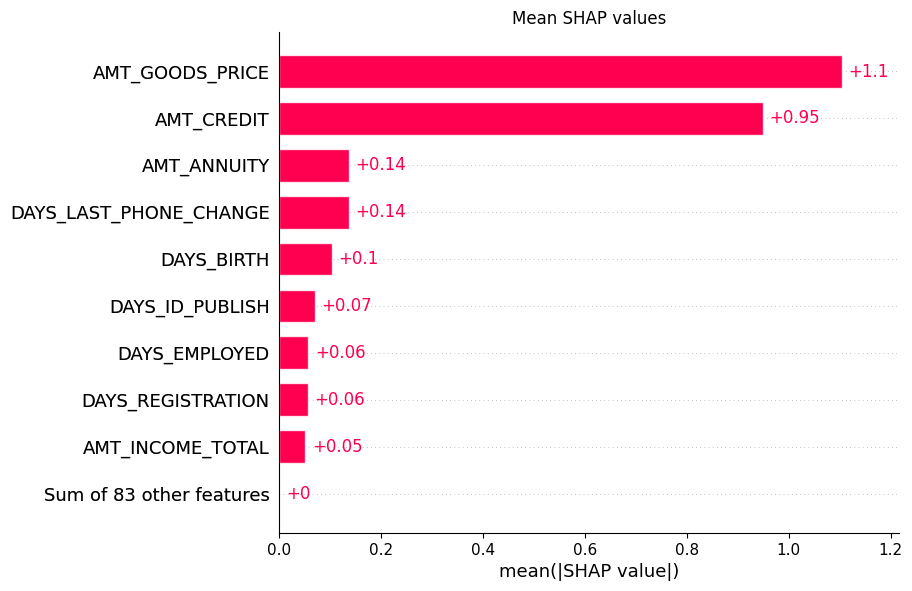

Model:  Logistic Regression
Pre-processing type:  WoE for categorical
Encoding type:  WoE and IV


In [67]:
shap_mean(model, X, "Logistic Regression", "WoE for categorical", "WoE and IV")

In [ ]:
shap_base(model, X, X_test, "Logistic Regression", "WoE for categorical", "WoE and IV")

In [ ]:
lime_interp(model, X_train, X_test)

# 🔹 XGBoost | Все модели 

## Универсальная модель для обучения

In [108]:
def xgb_learn(X_train, y_train, X_test, y_test, n_estimator_best):

  clf = XGBClassifier(n_estimators=n_estimator_best, learning_rate=0.6)
  clf.fit(X_train, y_train)

  y_pred_test = clf.predict_proba(X_test)

  ras = roc_auc_score(y_test.values, y_pred_test[:,1])
  print("Ras: ", ras)

  return clf

In [98]:
def draw_xgb(model, X_train, y_train, X_test, y_test):
  
  # Predict on test for matrix
  y_pred_test = model.predict(X_test)
  mat = confusion_matrix(y_test, y_pred_test)
  labels = ['0', '1']
  
  sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='crest',
              xticklabels=labels, yticklabels=labels)
  
  plt.xlabel('Predicted label')
  plt.ylabel('Actual label')

  precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred_test, average='binary')

  print("Precision: ", precision)
  print("Recall: ", recall)
  print("F1-score: ", f1_score)

Поиск оптимального параметра:

In [70]:
def n_estimator_search(X_train, y_train, X_test, y_test):
  results = {'train_score': [], 'test_score': []}
  depths = range(1, 10, 2)

  best_n_estimators = 0
  scoren_estimators = 0


  for i in depths:
          param = {
            'n_estimators': i,
            }

          clf = XGBClassifier(n_estimators=i)
          clf.fit(X_train, y_train)
          # print ('score ', clf.score(x_test, y_test))

          # Снова аналогично сохраняем решения
          results['train_score'].append(clf.score(X_train, y_train))
          results['test_score'].append(clf.score(X_test, y_test))

          if clf.score(X_test, y_test) > scoren_estimators:
            best_n_estimators = i


  plt.figure(figsize=(13, 8))

  plt.plot(depths, results['train_score'], label='Трейн', color='red', marker='o')
  plt.plot(depths, results['test_score'], label='Тест', color='blue', marker='o')

  print('Best n_estimators: ', best_n_estimators)

  plt.title('Качество XGBoost при разном количестве моделей:')
  plt.xlabel('Количество моделей')
  plt.ylabel('Качество')
  plt.legend()
  plt.show()

  return best_n_estimators

Поиск оптимального шага:

In [71]:
def learning_rate_search(X_train, y_train, X_test, y_test):
  results = {'train_score': [], 'test_score': []}
  depths = [0.5, 0.6, 0.7]
  best_learning_rate = 0
  score_learning_rate = 0


  for i in range(9):
          param = {
            'learning_rate': depths[i],
            }

          clf = XGBClassifier(learning_rate=depths[i])
          clf.fit(X_train, y_train)
          # print ('score ', clf.score(x_test, y_test))

          # Снова аналогично сохраняем решения
          results['train_score'].append(clf.score(X_train, y_train))
          results['test_score'].append(clf.score(X_test, y_test))

          if clf.score(X_test, y_test) > score_learning_rate:
            best_learning_rate = depths[i]


  plt.figure(figsize=(13, 8))

  plt.plot(depths, results['train_score'], label='Трейн', color='red', marker='o')
  plt.plot(depths, results['test_score'], label='Тест', color='blue', marker='o')


  print('Best learning_rate: ', best_learning_rate)

  plt.title('Качество XGBoost при разном темпе обучения:')
  plt.xlabel('Количество моделей')
  plt.ylabel('Качество')
  plt.legend()
  plt.show()

  return best_learning_rate

## 🌸 XGBoost на OneHot | DONE

In [99]:
df_xgb = df.copy()

Стандартная предобработка:

In [100]:
df_xgb = base_pre_processing(df_xgb)

OneHot Encoding:

In [101]:
df_xgb = pd.get_dummies(df_xgb)

Выборки:

In [102]:
X = df_xgb.drop(['TARGET'], axis=1)
y = df_xgb['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify=y)

Подбираем параметр:

In [103]:
# n_estimator_best = n_estimator_search(X_train, y_train, X_test, y_test)

Обучаем модель:

In [109]:
clf = xgb_learn(X_train, y_train, X_test, y_test, 3)

Ras:  0.7609950317440702


In [110]:
# draw_xgb(clf, X_train, y_train, X_test, y_test)

Интерпретируем:

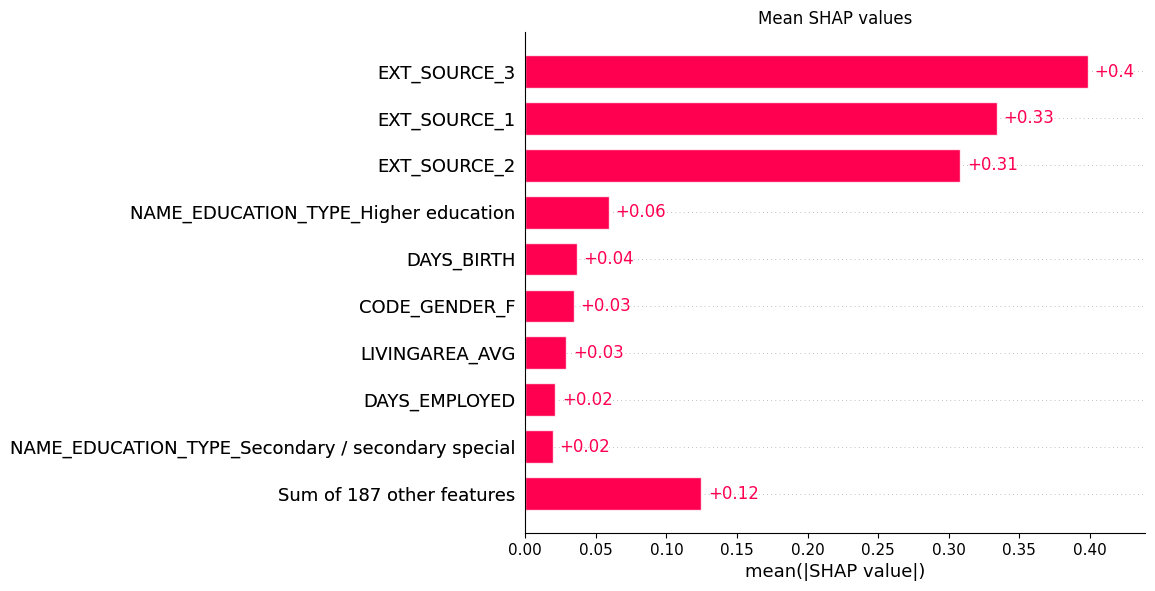

Model:  XGBoost
Pre-processing type:  Basic
Encoding type:  OneHot


In [111]:
shap_mean(clf, X_test, "XGBoost", "Basic", "OneHot")

In [112]:
shap_base(clf, X, X_test, "XGBoost", "Basic", "OneHot")

In [ ]:
lime_interp(clf, X_train, X_test)

Посмотрим feature_importances:

In [ ]:
feature_imp(clf, X)

## 🌸 XGBoost на Helmert | DONE

In [113]:
df_xgb_helmert = df.copy()

In [114]:
numeric_features_helmet = df_xgb_helmert.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_features_helmet.remove('TARGET')

categorical_helmet = df_xgb_helmert.select_dtypes(include=['object']).columns.tolist()

In [115]:
helmert_enc = HelmertEncoder(cols=categorical_helmet, drop_invariant=True)
X_categ = helmert_enc.fit_transform(df_xgb_helmert[categorical_helmet])

Intercept column might not be added anymore in future releases (c.f. issue #370)
Intercept column might not be added anymore in future releases (c.f. issue #370)


In [116]:
X = pd.concat([X_categ, df_xgb_helmert[numeric_features_helmet]], axis=1)
y = df_xgb_helmert['TARGET']

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify=y)

Подбираем параметр n_estimators:

Best n_estimators:  9


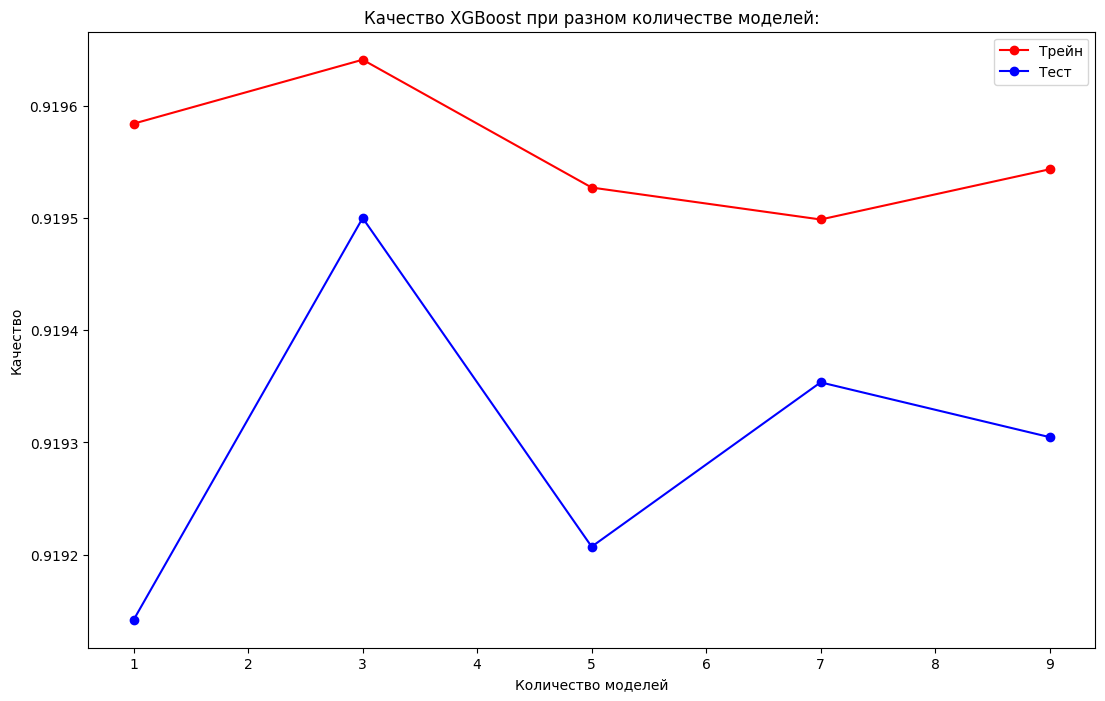

In [ ]:
n_estimator_best = n_estimator_search(X_train, y_train, X_test, y_test)

Обучаем:

In [118]:
clf = xgb_learn(X_train, y_train, X_test, y_test, n_estimator_best)

Ras:  0.7175561160460289


In [ ]:
draw_xgb(clf, X_train, y_train, X_test, y_test)

Посмотрим feature_importances:

In [ ]:
feature_imp(clf, X)

Посмотрим SHAP:

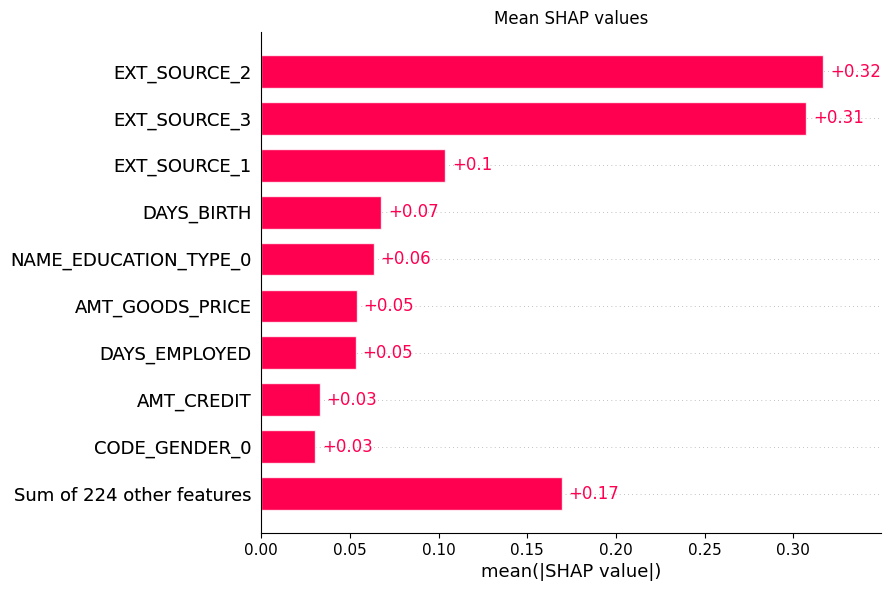

Model:  XGBoost
Pre-processing type:  Basic
Encoding type:  Helmert


In [119]:
shap_mean(clf, X_test, "XGBoost", "Basic", "Helmert")

In [ ]:
shap_base(clf, X, X_test, "XGBoost", "Basic", "OneHot")

In [ ]:
lime_interp(clf, X_train, X_test)

## 🌸 XGBoost на Frequency (DONE)

In [120]:
df_freq = df.copy()

Ручная предобработка:

In [121]:
df_freq = base_pre_processing(df_freq)

Кодируем Frequency:

In [122]:
categorical_freq = df_freq.select_dtypes(include=['object']).columns.tolist()
numeric_features_freq = df_freq.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [123]:
encoder = CountEncoder(cols=categorical_freq, normalize=True)
df_freq_cat = encoder.fit_transform(df_freq[categorical_freq])

In [124]:
df_freq_done = pd.concat([df_freq_cat, df_freq[numeric_features_freq]], axis=1)

In [125]:
X = df_freq_done.drop(['TARGET'], axis=1)
y = df_freq_done['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify=y)

Обучаем:

In [126]:
clf = xgb_learn(X_train, y_train, X_test, y_test, 3)

Ras:  0.7621940344564189


In [ ]:
draw_xgb(clf, X_train, y_train, X_test, y_test)

Интерпретируем:

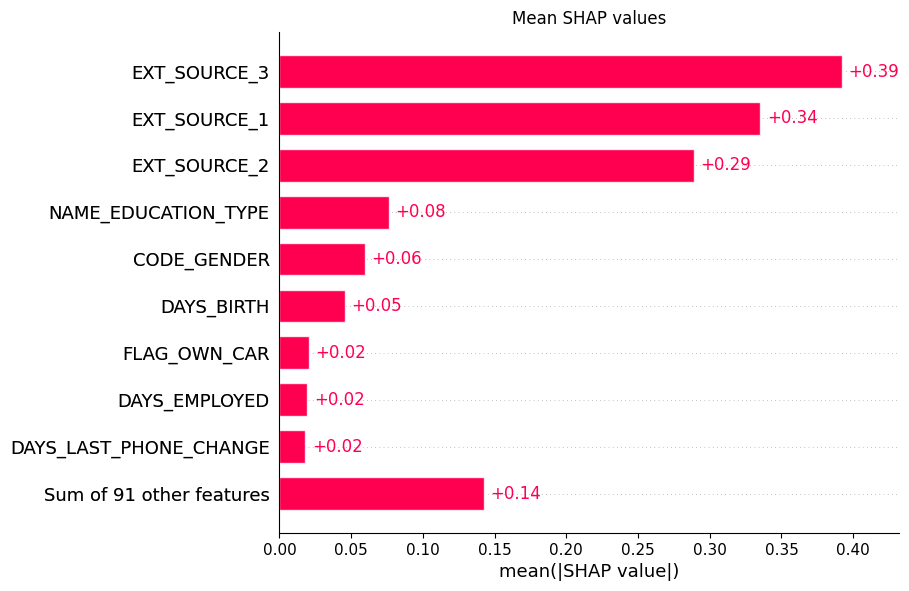

Model:  XGBoost
Pre-processing type:  Basic
Encoding type:  Helmert


In [127]:
shap_mean(clf, X_test, "XGBoost", "Basic", "Helmert")

In [ ]:
shap_base(clf, X, X_test, "XGBoost", "Basic", "OneHot")

In [ ]:
lime_interp(clf, X_train, X_test)

## 🌸 XGBoost с WoE на всех данных | DONE

In [128]:
df_xgb_woe_all = df.copy()

Все признаки кодируем через WoE и отбираем по Information Value с порогом 0.02:

In [129]:
X_train, y_train, X_test, y_test = woe_for_all(df_xgb_woe_all, 0.02)

divide by zero encountered in log


Подбираем параметр:

In [ ]:
n_estimator_best = n_estimator_search(X_train, y_train, X_test, y_test)

Обучаем:

In [130]:
clf = xgb_learn(X_train, y_train, X_test, y_test, 3)

Ras:  0.6838973032006102


In [ ]:
draw_xgb(clf, X_train, y_train, X_test, y_test)

Посмотрим feature_importantance_ 

In [ ]:
feature_imp(clf, X)

Посмотрим SHAP:

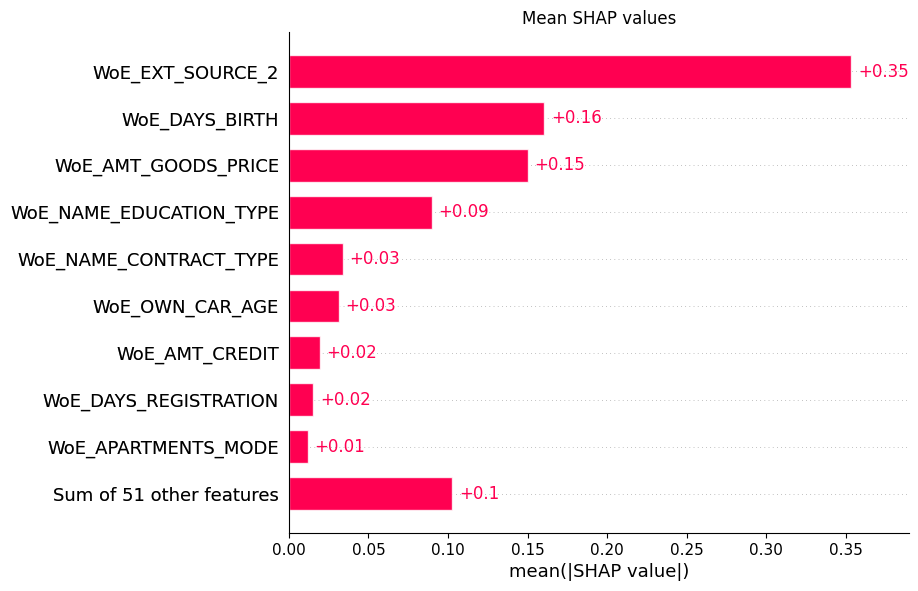

Model:  XGBoost
Pre-processing type:  Basic
Encoding type:  Helmert


In [131]:
shap_mean(clf, X_test, "XGBoost", "Basic", "Helmert")

In [ ]:
shap_base(clf, X_train, X_test, "XGBoost", "Basic", "Helmert")

In [ ]:
lime_interp(clf, X_train, X_test)

## 🌸 XGBoost на WoE только для категориальных

In [138]:
df_xgb_woe_cat = df.copy()

Предварительная обработка данных:

In [139]:
df_xgb_woe_cat = base_pre_processing(df_xgb_woe_cat)

Теперь категориальные признаки кодируем через WoE и отбираем по Information Value с порогом 0.02:

In [140]:
X_train, y_train, X_test, y_test = woe_for_cat(df_xgb_woe_cat, 0.02)

divide by zero encountered in log


Подбираем параметр:

In [ ]:
# n_estimator_best = n_estimator_search(X_train, y_train, X_test, y_test)

Обучаем модель:

In [141]:
clf = xgb_learn(X_train, y_train, X_test, y_test, 3)

Ras:  0.7607758779295595


Precision:  0.6345260223048327
Recall:  0.3667741069030352
F1-score:  0.46485106382978725


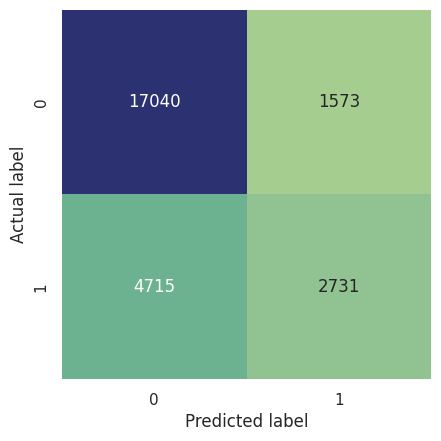

In [ ]:
draw_xgb(clf, X_train, y_train, X_test, y_test)

Интерпретируем:

In [ ]:
X = pd.concat([X_train, X_test], axis=0)

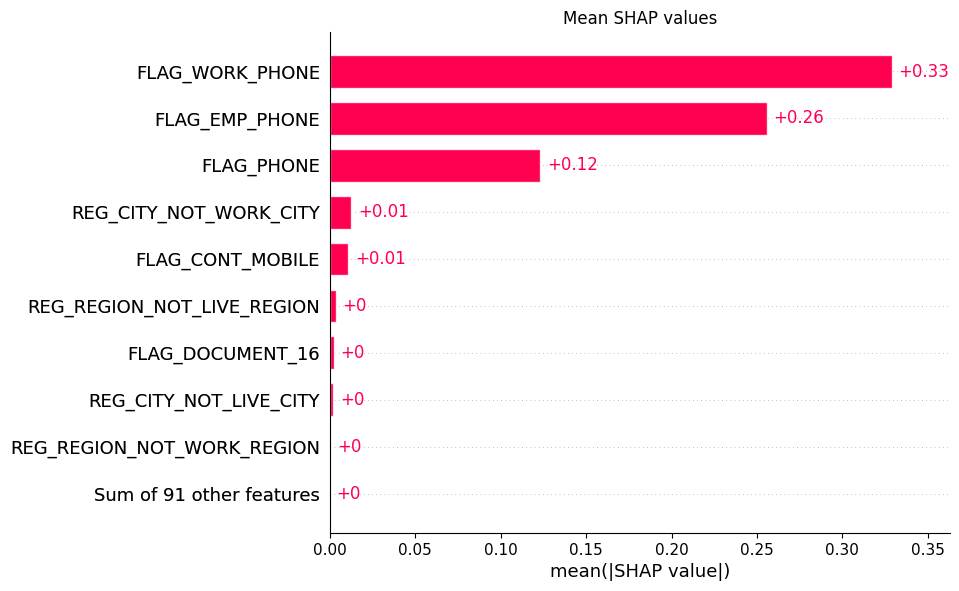

Model:  XGBoost
Pre-processing type:  WoE for categorical
Encoding type:  WoE and IV


In [142]:
shap_mean(clf, X, "XGBoost", "WoE for categorical", "WoE and IV")

In [ ]:
shap_base(clf, X, X_test, "XGBoost", "WoE for categorical", "WoE and IV")

In [ ]:
lime_interp(clf, X_train, X_test)

Высчитываем средние потери при использовании этой модели от одного ложновыданного кредита:

In [ ]:
count_of_client = len(y_test)

error_acc = []
for _ in range(count_of_client):

  loan_amount = X_test.iloc[_]['AMT_CREDIT']
  actual_losse = y_test[_] * loan_amount

   # берем именно вероятность дефолта (1)
  predicted_losse = y_pred_test[_][1] * X_test.iloc[_]['AMT_CREDIT']

  error = predicted_losse - actual_losse
  error_acc.append(error) 


In [ ]:
import statistics
statistics.mean(error_acc)

13944.1250316331

# 🔷 Sequential | Все модели

## Дополнительные функции

Функция **conf_matrix** удобно отображает confusion_matrix и сразу считает необходимые метрики:

In [145]:
def conf_matrix(model, X_test, y_test):
  y_predicted = model.predict(X_test) > 0.05

  mat = confusion_matrix(y_test, y_predicted)
  labels = ['0', '1']
  
  sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='crest',
              xticklabels=labels, yticklabels=labels)
  
  plt.xlabel('Predicted label')
  plt.ylabel('Actual label')

  precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_predicted, average='binary')

  print("Precision:", precision)
  print("Recall:", recall)
  print("F1-score:", f1_score)

Функция **print_learning** строит график отражающий обучение:

In [146]:
def print_learning(hist):
  import matplotlib.pyplot as plt
  %matplotlib inline
  import seaborn as sns
  sns.set()
  
  acc = hist.history['binary_accuracy']
  val = hist.history['val_binary_accuracy']
  epochs = range(1, len(acc) + 1)
  
  plt.plot(epochs, acc, '-', label='Training accuracy')
  plt.plot(epochs, val, ':', label='Validation accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('sparse_categorical_accuracy')
  plt.legend(loc='lower right')
  plt.plot()

## 🌸 Sequential на WoE для всех данных (DONE)

In [186]:
df_nn = df.copy()

In [189]:
X_train, y_train, X_test, y_test = woe_for_all(df_nn, 0.02)

divide by zero encountered in log


In [190]:
feature_names = X_train.columns.tolist()  # save feature names

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_names)
X_test = pd.DataFrame(scaler.transform(X_test), columns=feature_names)

Выборки:

In [191]:
model = Sequential()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01), input_dim=60))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', ))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()]) 

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['sparse_categorical_accuracy'])
# model.compile(optimizer='adam', loss=(lambda y_pred, y_true: weighted_binary_crossentropy(y_pred, y_true, class_weights)), metrics=['accuracy'])

In [254]:
hist = model.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.2, callbacks=[early_stopping])

In [255]:
y_pred_prob = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("ROC AUC Score:", roc_auc)

In [256]:
conf_matrix(model, X_train, y_train)

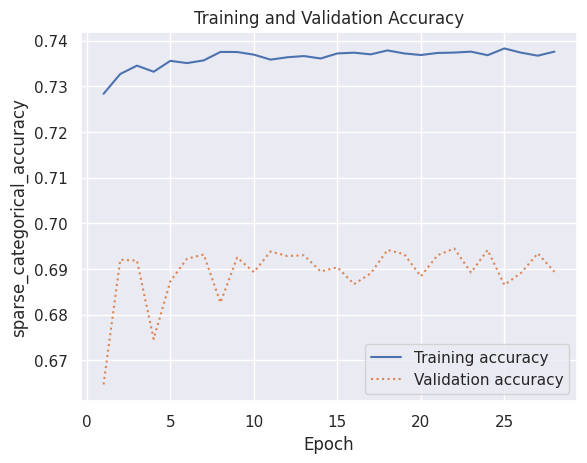

In [195]:
# print_learning(hist)

In [ ]:
background_data = shap.sample(X_test, 200) 

In [ ]:
# DeepExplainer to explain predictions of the model
explainer = shap.KernelExplainer(model, background_data)
# compute shap values
shap_values = explainer.shap_values(shap.sample(X_test, 200))

  0%|          | 0/200 [00:00<?, ?it/s]

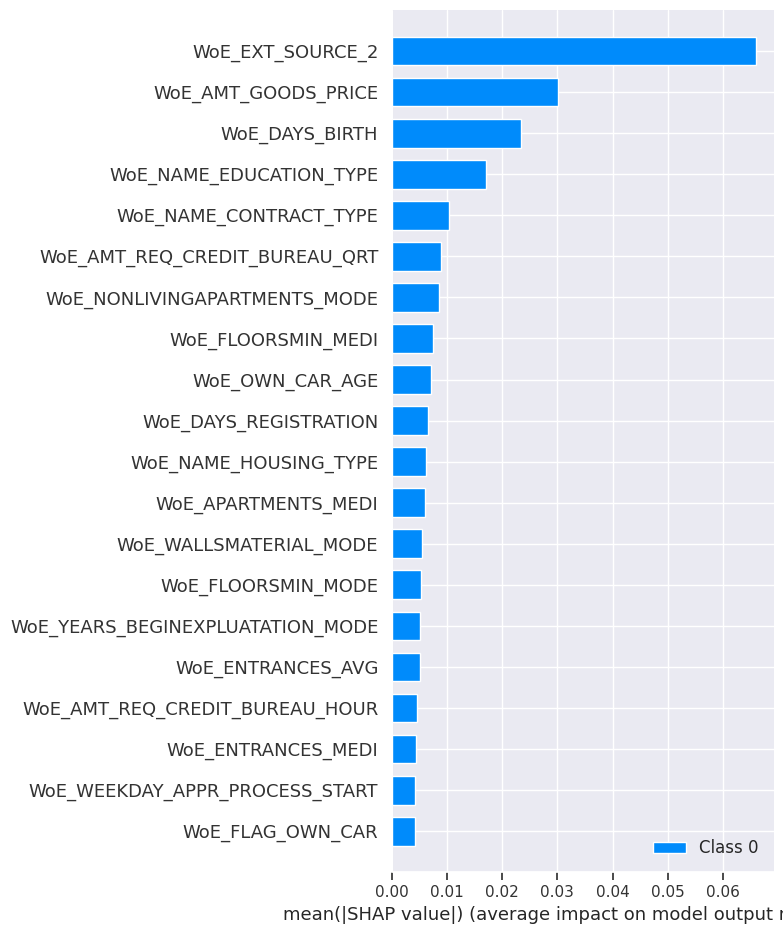

In [ ]:
shap.summary_plot(shap_values, background_data)

## 🌸 Sequential на WoE для категориальных (DONE)

In [153]:
df_nn = df.copy()

Стандартная предобработка в этом случае нужна, тк мы будем WoE преобразовывать только категориальные признаки:

In [154]:
df_nn = base_pre_processing(df_nn)

Теперь кодируем WoE на категориальных:

In [155]:
X_train, y_train, X_test, y_test = woe_for_cat(df_nn, 0.02)

divide by zero encountered in log


In [156]:
feature_names = X_train.columns.tolist()  # save feature names

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_names)
X_test = pd.DataFrame(scaler.transform(X_test), columns=feature_names)

In [157]:
model = Sequential()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01), input_dim=92))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', ))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])

In [257]:
hist = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.1, callbacks=[early_stopping])

In [159]:
y_pred_prob = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("ROC AUC Score:", roc_auc)

815/815 [==============================] - 3s 3ms/step
ROC AUC Score: 0.7757734128474199


1901/1901 [==============================] - 7s 4ms/step
Precision: 0.29065071305280443
Recall: 0.9982732819155059
F1-score: 0.4502186976780406


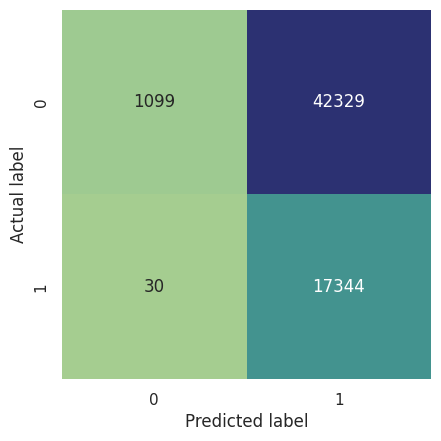

In [ ]:
conf_matrix(model, X_train, y_train)

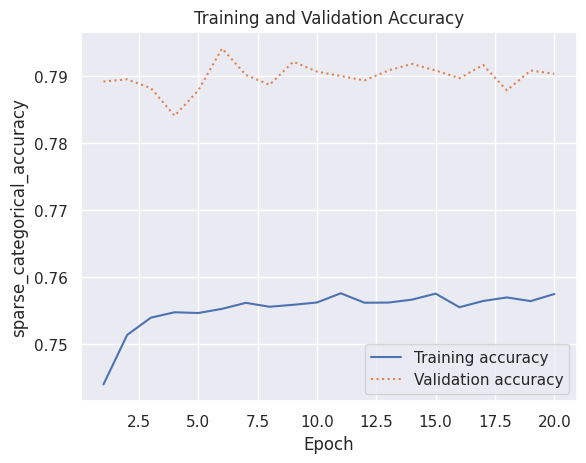

In [ ]:
print_learning(hist)

In [ ]:
background_data = shap.sample(X_test, 150) 

In [ ]:
# DeepExplainer to explain predictions of the model
explainer = shap.KernelExplainer(model, background_data)
# compute shap values
shap_values = explainer.shap_values(shap.sample(X_test, 100))

  0%|          | 0/100 [00:00<?, ?it/s]

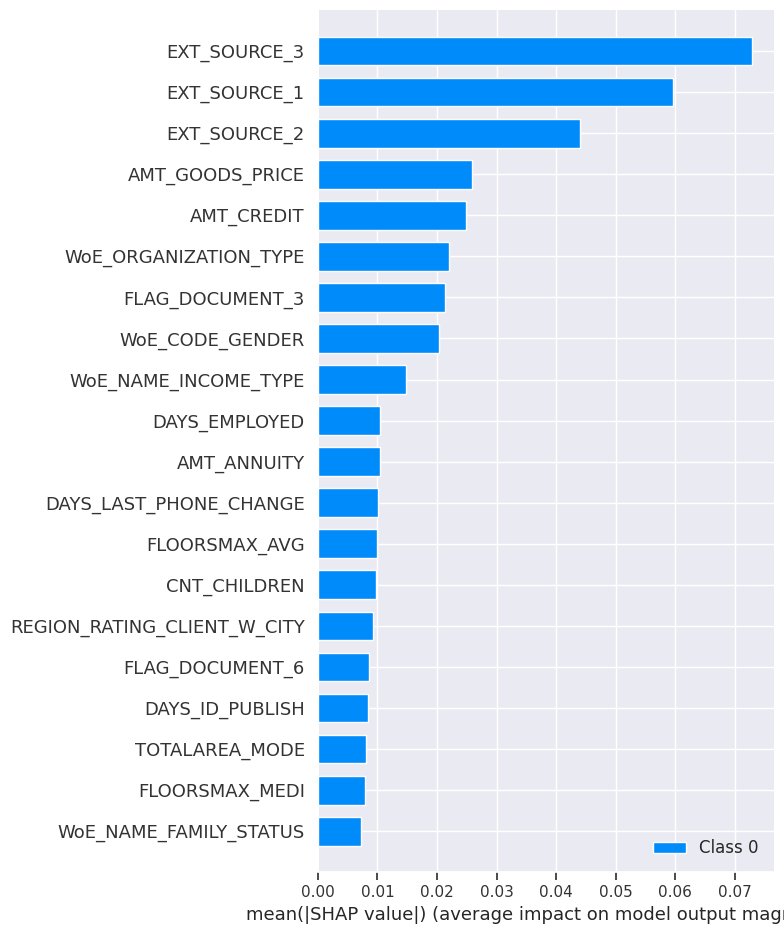

In [ ]:
shap.summary_plot(shap_values, background_data)

## 🌸 Sequential на Helmert (DONE)

In [160]:
df_nn = df.copy()

In [161]:
df_nn = base_pre_processing(df_nn)

In [162]:
numeric_features_nn = df_nn.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_features_nn.remove('TARGET')

categorical_nn = df_nn.select_dtypes(include=['object']).columns.tolist()

In [163]:
helmert_enc = HelmertEncoder(cols=categorical_nn, drop_invariant=True)
X_categ = helmert_enc.fit_transform(df_nn[categorical_nn])

Intercept column might not be added anymore in future releases (c.f. issue #370)
Intercept column might not be added anymore in future releases (c.f. issue #370)


In [164]:
X = pd.concat([X_categ, df_nn[numeric_features_nn]], axis=1)
y = df_nn['TARGET']

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify=y)

In [166]:
feature_names = X_train.columns.tolist()  # save feature names

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_names)
X_test = pd.DataFrame(scaler.transform(X_test), columns=feature_names)

In [167]:
model = Sequential()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01), input_dim=182))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', ))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])

In [258]:
hist = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1, callbacks=[early_stopping])

In [ ]:
y_pred_prob = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("ROC AUC Score:", roc_auc)

543/543 [==============================] - 1s 2ms/step
ROC AUC Score: 0.7744727057379218


2172/2172 [==============================] - 6s 3ms/step
Precision: 0.29017667637630457
Recall: 0.9983883964544722
F1-score: 0.44966146099146


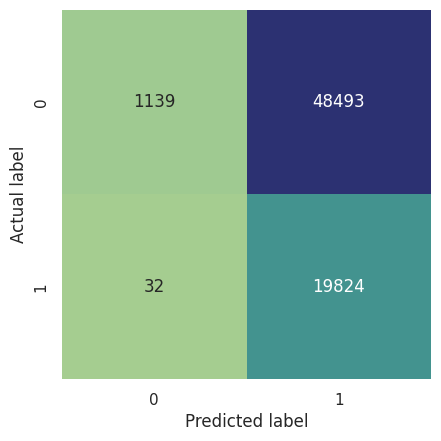

In [ ]:
conf_matrix(model, X_train, y_train)

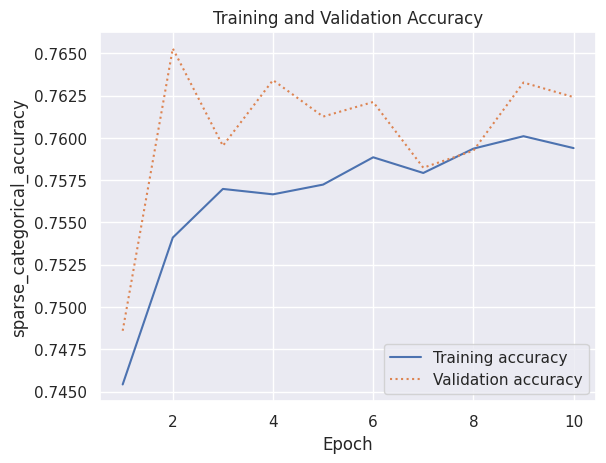

In [ ]:
print_learning(hist)

In [ ]:
background_data = shap.sample(X_test, 200) 

In [ ]:
# DeepExplainer to explain predictions of the model
explainer = shap.KernelExplainer(model, background_data)
# compute shap values
shap_values = explainer.shap_values(shap.sample(X_test, 100))

  0%|          | 0/100 [00:00<?, ?it/s]

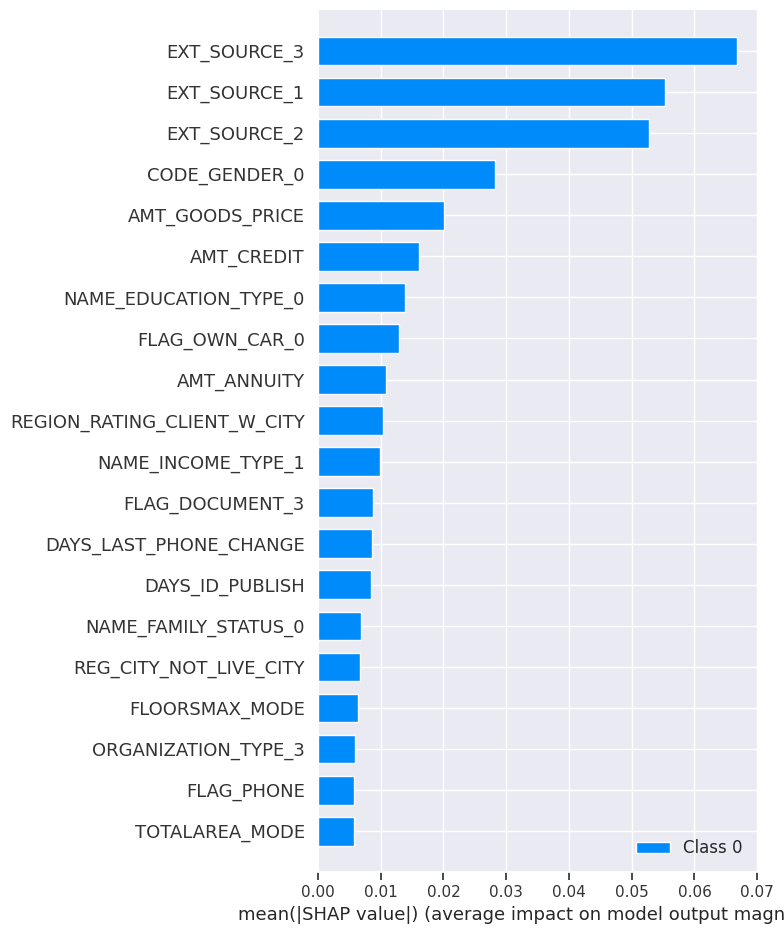

In [ ]:
shap.summary_plot(shap_values, background_data)

## 🌸 Sequential на OneHot (DONE)



In [168]:
df_nn = df.copy()

Стандартная предобработка:

In [169]:
df_nn = base_pre_processing(df_nn)

OneHot Encoding:

In [170]:
df_nn = pd.get_dummies(df_nn)

Выборки:

In [171]:
X = df_nn.drop(['TARGET'], axis=1)
y = df_nn['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify=y)

In [172]:
feature_names = X_train.columns.tolist()  # save feature names

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_names)
X_test = pd.DataFrame(scaler.transform(X_test), columns=feature_names)

In [ ]:
model = Sequential()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.add(Dense(198, activation='relu', kernel_regularizer=l2(0.01), input_dim=197))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', ))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])

In [259]:
hist = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_split=0.1, callbacks=[early_stopping])

In [ ]:
y_pred_prob = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("ROC AUC Score:", roc_auc)

543/543 [==============================] - 1s 2ms/step
ROC AUC Score: 0.7680246598851512


2172/2172 [==============================] - 4s 2ms/step
Precision: 0.29138040104159
Recall: 0.9974818694601129
F1-score: 0.4510127634380444


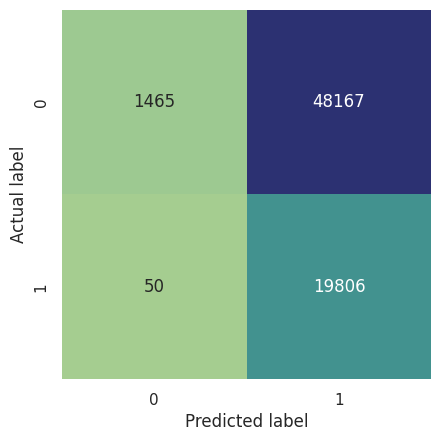

In [ ]:
conf_matrix(model, X_train, y_train)

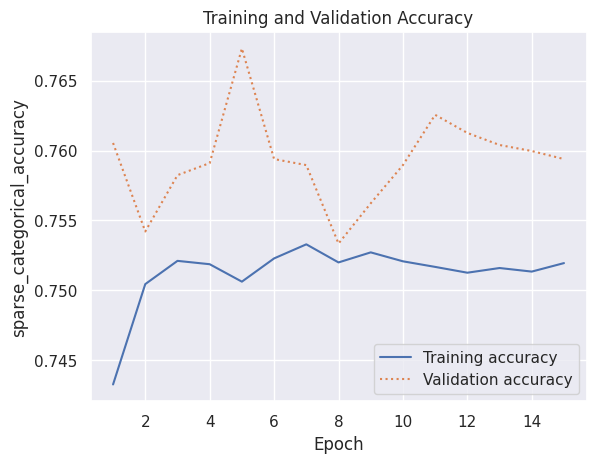

In [ ]:
print_learning(hist)

Интерпретируем:

In [ ]:
background_data = shap.sample(X_test, 200) 

In [ ]:
# DeepExplainer to explain predictions of the model
explainer = shap.KernelExplainer(model, background_data)
# compute shap values
shap_values = explainer.shap_values(shap.sample(X_test, 100))

  0%|          | 0/100 [00:00<?, ?it/s]

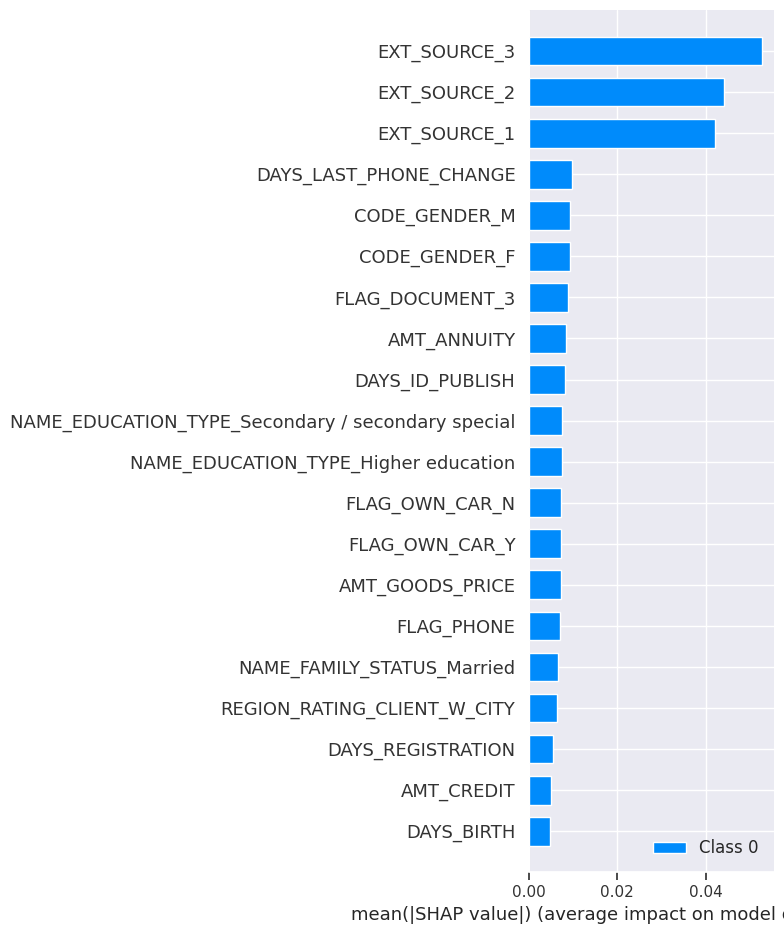

In [ ]:
shap.summary_plot(shap_values, background_data)

## 🌸 Sequential на Frequency (DONE)

In [ ]:
df_freq = df.copy()

Ручная предобработка:

In [ ]:
df_freq = base_pre_processing(df_freq)

Кодируем Frequency:

In [ ]:
categorical_freq = df_freq.select_dtypes(include=['object']).columns.tolist()
numeric_features_freq = df_freq.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [ ]:
encoder = CountEncoder(cols=categorical_freq, normalize=True)
df_freq_cat = encoder.fit_transform(df_freq[categorical_freq])

In [ ]:
df_freq_done = pd.concat([df_freq_cat, df_freq[numeric_features_freq]], axis=1)

In [ ]:
X = df_freq_done.drop(['TARGET'], axis=1)
y = df_freq_done['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify=y)

In [ ]:
feature_names = X_train.columns.tolist()  # save feature names

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_names)
X_test = pd.DataFrame(scaler.transform(X_test), columns=feature_names)

In [ ]:
model = Sequential()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01), input_dim=100))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', ))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])

In [260]:
hist = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.1, callbacks=[early_stopping])

In [261]:
y_pred_prob = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("ROC AUC Score:", roc_auc)

In [262]:
conf_matrix(model, X_train, y_train)

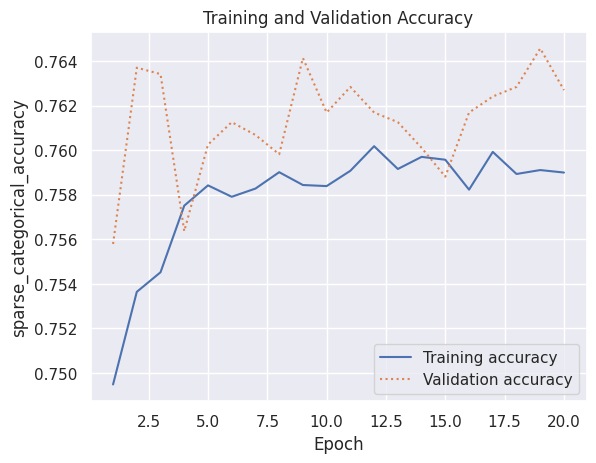

In [ ]:
print_learning(hist)

In [ ]:
background_data = shap.sample(X_test, 200)

In [ ]:
# DeepExplainer to explain predictions of the model
explainer = shap.KernelExplainer(model, background_data)
# compute shap values
shap_values = explainer.shap_values(shap.sample(X_test, 100))

  0%|          | 0/100 [00:00<?, ?it/s]

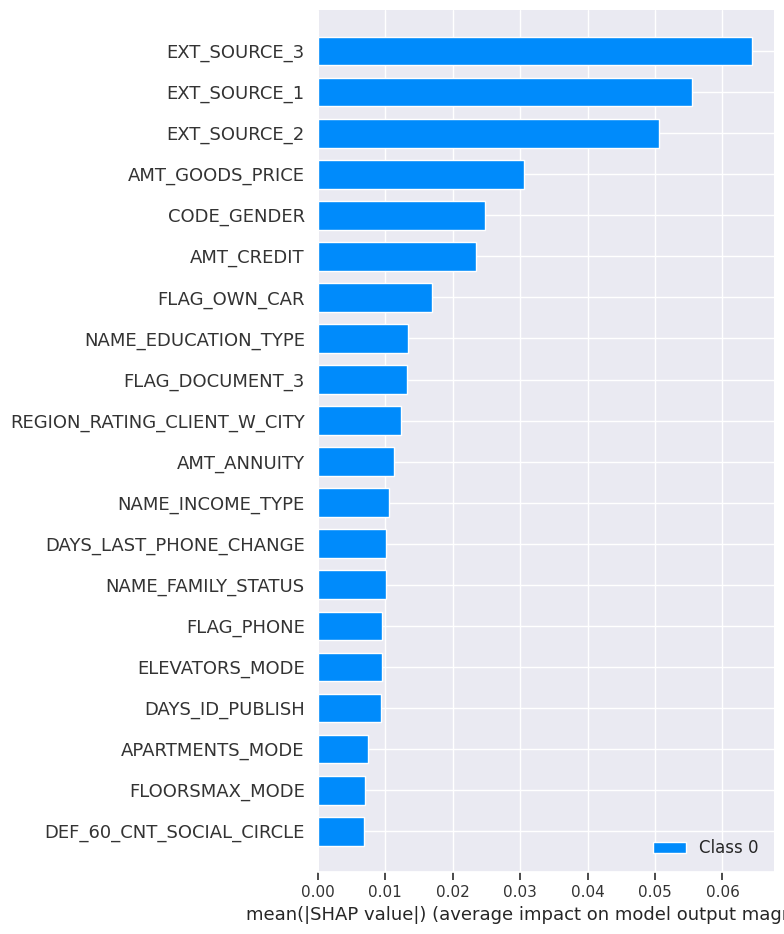

In [ ]:
shap.summary_plot(shap_values, background_data)

Высчитываем средние потери при использовании этой модели от одного ложновыданного кредита:

In [ ]:
count_of_client = len(X_test)

error_acc = []

for _ in X_test.index:

  loan_amount = X.iloc[_]['AMT_CREDIT']

  actual_losse = y.iloc[_] * loan_amount

  # Берем именно вероятность дефолта (1)
  predicted_losse = float(y_pred_prob[_]) *loan_amount

  error = predicted_losse - actual_losse
  error_acc.append(error) 

In [ ]:
statistics.mean(error_acc)

172027.35196137356

# CatBoost (не полноценные эксперименты)

In [199]:
# !pip install catboost

In [200]:
from catboost import CatBoostClassifier

In [241]:
df_cat = df.copy()

# df_cat = df_cat.drop(['EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1)

In [242]:
df_cat = base_pre_processing(df_cat)

In [243]:
X = df_cat.drop(['TARGET'], axis=1)
Y = df_cat['TARGET']

In [244]:
categorical = X.select_dtypes(include=['object']).columns.tolist()

In [245]:
X_train, X_validation, y_train, y_validation = train_test_split(X, Y, train_size=0.8, random_state=1234, stratify=Y)

In [249]:
best_model = CatBoostClassifier(
   iterations=100,
   learning_rate = 0.03,
   loss_function='CrossEntropy',
   use_best_model=True,
   depth=6
)

best_model.fit(
  X_train, y_train,
  cat_features=categorical,
  eval_set=(X_validation, y_validation),
  early_stopping_rounds=50,
  plot=True
)

preds_class = best_model.predict_proba(X_validation)
ras = roc_auc_score(y_validation.values, preds_class[:, 1])

print(" ROC-AUC ", ras)


In [250]:
y_pred_test = best_model.predict(X_validation)
mat = confusion_matrix(y_validation, y_pred_test)
labels = ['0', '1']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='crest',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

precision, recall, f1_score, support = precision_recall_fscore_support(y_validation, y_pred_test, average='binary')

print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1_score)

In [251]:
plt.figure(figsize=(10, 20))
plt.barh(X.columns, best_model.feature_importances_)

plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


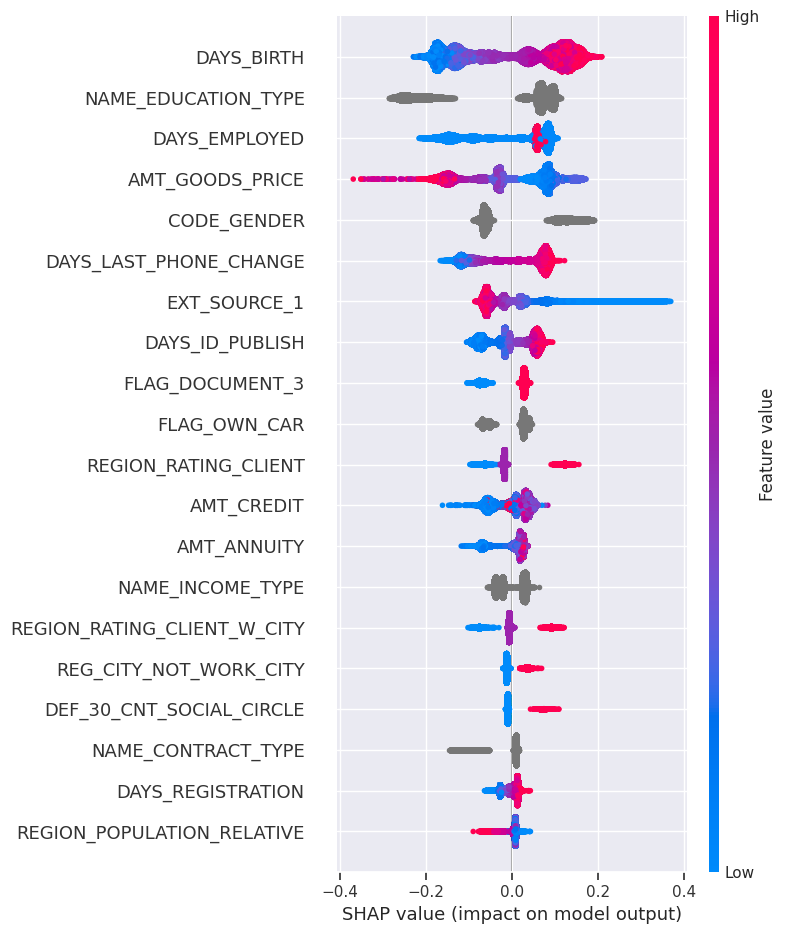

In [232]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)
     
shap.summary_plot(shap_values, X)

# Value для бизнеса:

In [252]:
def calculate_value(y_test, y_pred, loan_amounts, interest_rate):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    profit_per_loan = loan_amounts * interest_rate
    loss_per_loan = loan_amounts

    tp_profit = 0
    tp_loss = tp * loss_per_loan.mean() 

    tn_profit = tn * profit_per_loan.mean()
    tn_loss = 0

    fp_profit = 0
    fp_loss = fp * profit_per_loan.mean()

    fn_profit = fn * profit_per_loan.mean()
    fn_loss = fn * loss_per_loan.mean()

    total_profit = tp_profit + tn_profit + fp_profit + fn_profit
    total_loss = tp_loss + tn_loss + fp_loss + fn_loss

    return total_profit - total_loss

## Другой вариант:

In [253]:
def calculate_average_loss(y_test, y_pred_prob, loan_amounts):

    actual_losses = y_test * loan_amounts

    predicted_losses = y_pred_prob * loan_amounts 

    error = predicted_losses - actual_losses
    
    return error

# Sentence Embedding (не включено в эксперименты)

In [ ]:
sentences = df['text_var'].apply(lambda x: x.split()).tolist()
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1)

df['text_var_encoded'] = df['text_var'].apply(lambda x: word2vec_model.wv[x] if x in word2vec_model.wv else np.zeros(100))

lr_model = LogisticRegression()
lr_model.fit(df.drop('target', axis=1), df['target'])

xgb_model = XGBClassifier()
xgb_model.fit(df.drop('target', axis))